# 相関係数

ブートストラップ法を用いて日経平均と野村BPI総合の相関係数を求める．

In [144]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

FIGSIZE = (1.618*6, 6)

In [135]:
ticker_list = ['^N225', '2510.T']
tickers = yf.Tickers(ticker_list)
df = tickers.history(period='max')
df = pl.DataFrame(
    {
        'Date': df.index,
        'N225': df['Close']['^N225'],
        '2510': df['Close']['2510.T']
    }
)
df = df.drop_nulls()

[*********************100%***********************]  2 of 2 completed


In [162]:
first_of_n225 = np.log(df[0, 1])
first_of_2510 = np.log(df[0, 2])
df = df.with_columns([
    (np.exp(pl.col('N225').log() - first_of_n225) - 1).alias('N225_return'),
    (np.exp(pl.col('2510').log() - first_of_2510) - 1).alias('2510_return'),
    (pl.col('N225').log() - pl.col('N225').log().shift(1)).alias('N225_diff').fill_null(0),
    (pl.col('2510').log() - pl.col('2510').log().shift(1)).alias('2510_diff').fill_null(0)
])

## plot

Text(0, 0.5, 'Return')

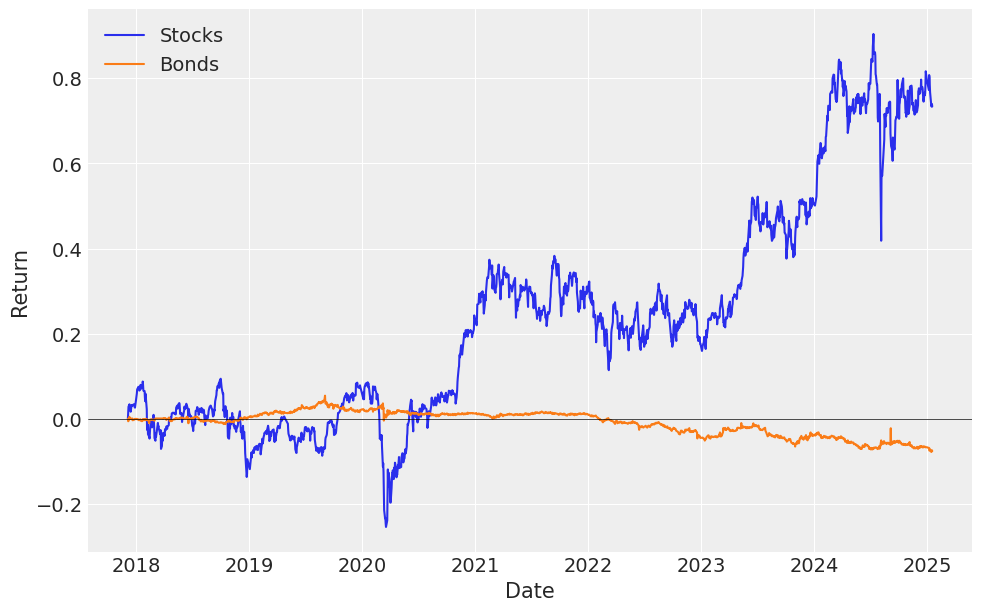

In [156]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.lineplot(data=df, x='Date', y='N225_return', ax=ax, label='Stocks')
sns.lineplot(data=df, x='Date', y='2510_return', ax=ax, label='Bonds')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Return')

<Axes: xlabel='2510', ylabel='N225'>

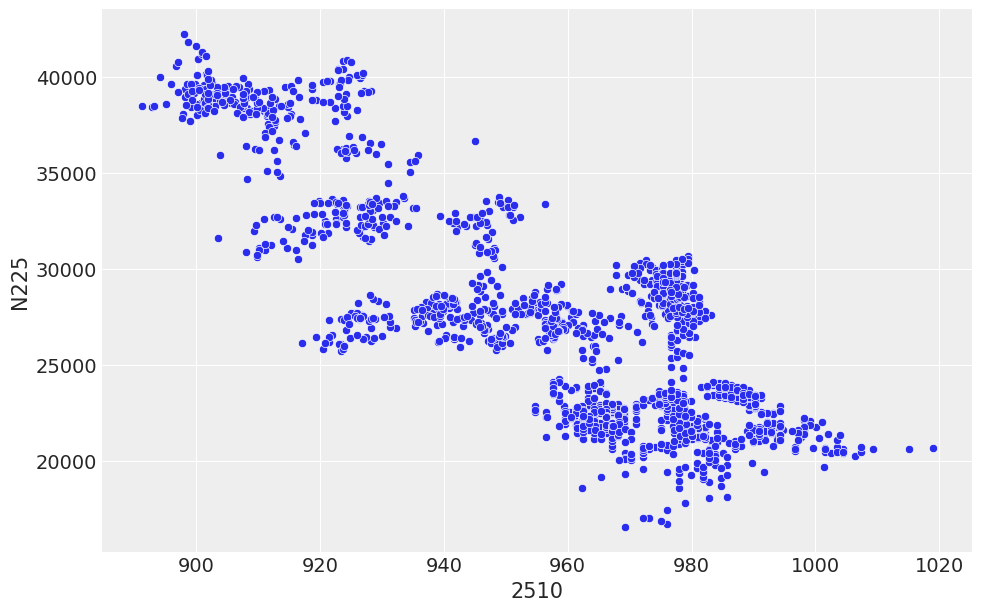

In [157]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.scatterplot(data=df, x='2510', y='N225')

In [141]:
boot_coef = []
boot_num = 10000
for i in range(boot_num):
    df_pd = df.to_pandas()
    df_boot = df_pd.sample(frac=1, replace=True)
    boot_coef.append(np.corrcoef(df_boot['N225'], df_boot['2510'])[0, 1])


mean: -0.81
std: 0.01


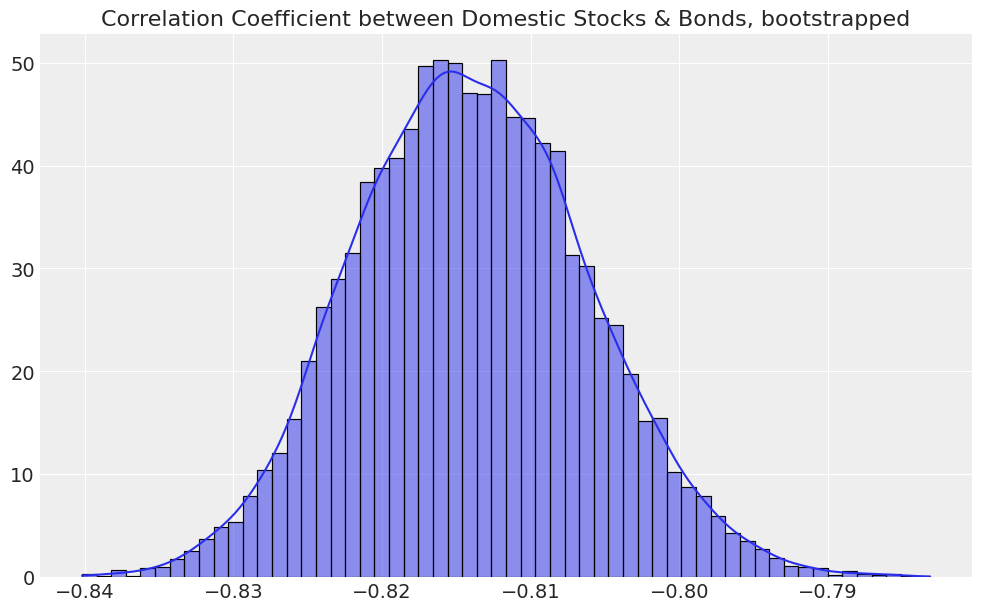

In [142]:
mean_coef = np.mean(boot_coef)
std_coef = np.std(boot_coef)

print(f'mean: {mean_coef:.2f}')
print(f'std: {std_coef:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
sns.histplot(boot_coef,  kde=True, stat='density', ax=ax)
ax.set_title('Correlation Coefficient between Domestic Stocks & Bonds, bootstrapped')
ax.set_ylabel('')
plt.show()

## Rebalance

In [165]:
df

Date,N225,2510,N225_return,2510_return,N225_diff,2510_diff
datetime[ns],f64,f64,f64,f64,f64,f64
2017-12-06 00:00:00,22177.039062,966.182007,0.0,0.0,0.0,0.0
2017-12-07 00:00:00,22498.029297,960.9646,0.014474,-0.0054,0.01437,-0.005415
2017-12-08 00:00:00,22811.080078,961.698975,0.02859,-0.00464,0.013819,0.000764
2017-12-11 00:00:00,22938.730469,971.012878,0.034346,0.005,0.00558,0.009638
2017-12-12 00:00:00,22866.169922,966.182007,0.031074,0.0,-0.003168,-0.004988
…,…,…,…,…,…,…
2025-01-10 00:00:00,39190.398438,897.0,0.767161,-0.071603,-0.010526,0.001115
2025-01-14 00:00:00,38474.300781,891.200012,0.734871,-0.077606,-0.018441,-0.006487
2025-01-15 00:00:00,38444.578125,892.900024,0.733531,-0.075847,-0.000773,0.001906


In [209]:
days = 252
rebalance_frequency = 21

# return
stock_mean = df['N225_return'][-1] / len(df)
stock_std = df['N225_diff'].std()
bond_mean = df['2510_return'][-1] / len(df)
bond_std = df['2510_diff'].std()

initial_investment = 10000
stock_weight = 0.5
bond_weight = 0.5
portfolio_value = initial_investment

portfolio_values = []

for day in range(len(df)):
    # daily return
    stock_value = portfolio_value * stock_weight * (1 + df['N225_return'][day])
    bond_value = portfolio_value * bond_weight * (1 + df['2510_return'][day])
    portfolio_value = stock_value + bond_value
    
    # adjust weights
    if (day + 1) % rebalance_frequency == 0:
        total_value = stock_value + bond_value
        stock_weight = 0.5
        bond_weight = 0.5
        portfolio_value = total_value
        
    # record
    portfolio_values.append(portfolio_value)
    
df = df.with_columns(
    pl.Series(name='portfolio', values=portfolio_values)
)

In [194]:
day = 1
portfolio_value = 1000

stock_value = portfolio_value * stock_weight * (1 + df['N225_diff'][day])
bond_value = portfolio_value * bond_weight * (1 + df['2510_diff'][day])
portfolio_value = stock_value + bond_value

print(f'stock: {stock_value}')
print(f'bond_value: {bond_value}')
print(f'portfolio_value: {portfolio_value}')

stock: 507.18512069379426
bond_value: 497.2926709590597
portfolio_value: 1004.477791652854


In [195]:
df

Date,N225,2510,N225_return,2510_return,N225_diff,2510_diff,portfolio
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2017-12-06 00:00:00,22177.039062,966.182007,0.0,0.0,0.0,0.0,10000.0
2017-12-07 00:00:00,22498.029297,960.9646,0.014474,-0.0054,0.01437,-0.005415,10045.369822
2017-12-08 00:00:00,22811.080078,961.698975,0.02859,-0.00464,0.013819,0.000764,10165.663277
2017-12-11 00:00:00,22938.730469,971.012878,0.034346,0.005,0.00558,0.009638,10365.651899
2017-12-12 00:00:00,22866.169922,966.182007,0.031074,0.0,-0.003168,-0.004988,10526.703394
…,…,…,…,…,…,…,…
2025-01-10 00:00:00,39190.398438,897.0,0.767161,-0.071603,-0.010526,0.001115,8.9131e80
2025-01-14 00:00:00,38474.300781,891.200012,0.734871,-0.077606,-0.018441,-0.006487,1.1842e81
2025-01-15 00:00:00,38444.578125,892.900024,0.733531,-0.075847,-0.000773,0.001906,1.5736e81


In [215]:
portfolio_return = np.log(df['portfolio']) - np.log(df['portfolio'][0])
portfolio_return

portfolio
f64
0.0
0.004527
0.016431
0.035913
0.05133
…
177.183988
177.468138
177.752446


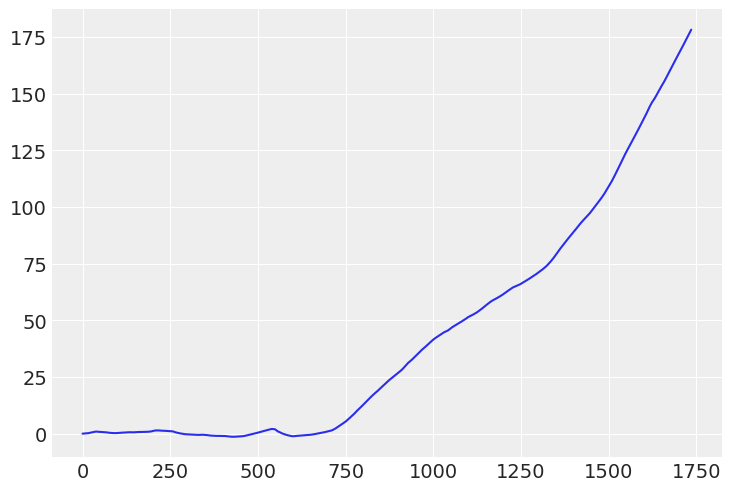

In [214]:
plt.plot(portfolio_return)